# Multiple Regression using Statsmodels

*This is part of a series of blog posts showing how to do common statistical learning techniques with Python. We provide only a small amount of background on the concepts and techniques we cover, so if you’d like a more thorough explanation check out [Introduction to Statistical Learning](https://www.statlearning.com) or sign up for the [free online course](http://online.stanford.edu/course/statistical-learning-winter-2014) run by the book's authors here.*

Earlier we covered Ordinary Least Squares regression with a single variable. In this posting we will build upon that by extending Linear Regression to multiple input variables giving rise to Multiple Regression, the workhorse of statistical learning.

We first describe Multiple Regression in an intuitive way by moving from a straight line in a single predictor case to a 2d plane in the case of two predictors. Next we explain how to deal with categorical variables in the context of linear regression. The final section of the post investigates basic extensions. This includes interaction terms and fitting non-linear relationships using polynomial regression.

## Understanding Multiple Regression

In Ordinary Least Squares Regression with a single variable we described the relationship between the predictor and the response with a straight line. In the case of multiple regression we extend this idea by fitting a $p$-dimensional hyperplane to our $p$ predictors.

We can show this for two predictor variables in a three dimensional plot. In the following example we will use the advertising dataset which consists of the *sales* of products and their advertising budget in three different media *TV*, *radio*, *newspaper*.

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

df_adv = pd.read_csv('https://raw.githubusercontent.com/Columbia-Intro-Data-Science/python-introduction-caitlinwang/master/www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)
X = df_adv[['TV', 'Radio']]
y = df_adv['Sales']
df_adv.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


The multiple regression model describes the response as a weighted sum of the predictors:

$Sales = \beta_0 + \beta_1 \times TV + \beta_2 \times Radio$

This model can be visualized as a 2-d plane in 3-d space:

![](https://d1pqsl2386xqi9.cloudfront.net/images/advertisement_3d.png)

The plot above shows data points above the hyperplane in white and points below the hyperplane in black. The color of the plane is determined by the corresonding predicted *Sales* values (blue = low, red = high). The Python code to generate the 3-d plot can be found in the [appendix](#appendix).

Just as with the single variable case, calling ``est.summary`` will give us detailed information about the model fit. You can find a description of each of the fields in the tables below in the previous blog post [here](http://www.datarobot.com/blog/ordinary-least-squares-in-python/).

In [5]:
X = df_adv[['TV', 'Radio']]
y = df_adv['Sales']

## fit a OLS model with intercept on TV and Radio
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()

est.summary()

/home/ebezerra/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           4.83e-98
Time:                        06:17:26   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                             778.4
Df Residuals:                     197   BIC:                             788.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9211      0.294      9.919      0.000       2.340       3.502
TV             0.0458      0.001     32.909      0.000       0.043       0.048
Radio          0.1880      0.008     23.382      0.000       0.172       0.204
==============================================================================
Omnibus:                       60.022   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.679
Skew:                          -1.323   Prob(JB):                     5.19e-33
Kurtosis:                       6.292   Cond. No.                         425.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

You can also use the formulaic interface of statsmodels to compute regression with multiple predictors. You just need append the predictors to the formula via a ``'+'`` symbol.

In [6]:
# import formula api as alias smf
import statsmodels.formula.api as smf

# formula: response ~ predictor + predictor
est = smf.ols(formula='Sales ~ TV + Radio', data=df_adv).fit()

## Handling Categorical Variables

Often in statistical learning and data analysis we encounter variables that are not quantitative. A common example is gender or geographic region. We would like to be able to handle them naturally. Here is a sample dataset investigating chronic heart disease.

In [7]:
import pandas as pd

df = pd.read_csv('http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/SAheart.data', index_col=0)

# copy data and separate predictors and response
X = df.copy()
y = X.pop('chd')

df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
row.names,,,,,,,,,,
1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


The variable *famhist* holds if the patient has a family history of coronary artery disease. The percentage of the response *chd* (chronic heart disease ) for patients with absent/present family history of coronary artery disease is:

In [8]:
# compute percentage of chronic heart disease for famhist
y.groupby(X.famhist).mean()

famhist
Absent     0.237037
Present    0.500000
Name: chd, dtype: float64

These two levels (absent/present) have a natural ordering to them, so we can perform linear regression on them, after we convert them to numeric. This can be done using ``pd.Categorical``.

In [18]:
import statsmodels.formula.api as smf

# encode df.famhist as a numeric via pd.Factor
df['famhist_ord'] = pd.Categorical(df.famhist).codes

est = smf.ols(formula="chd ~ famhist_ord", data=df).fit()

df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd,famhist_ord
row.names,,,,,,,,,,,
1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1,1
2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1,0
3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0,1
4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1,1
5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1,1


There are several possible approaches to encode categorical values, and statsmodels has built-in support for many of [them](http://statsmodels.sourceforge.net/devel/contrasts.html). In general these work by splitting a categorical variable into many different binary variables. The simplest way to encode categoricals is "dummy-encoding" which encodes a k-level categorical variable into k-1 binary variables. In statsmodels this is done easily using the ``C()`` function.

In [19]:
# a utility function to only show the coeff section of summary
from IPython.core.display import HTML
def short_summary(est):
    return HTML(est.summary().tables[1].as_html())

# fit OLS on categorical variables children and occupation
est = smf.ols(formula='chd ~ C(famhist)', data=df).fit()
short_summary(est)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2370,0.028,8.489,0.000,0.182,0.292
C(famhist)[T.Present],0.2630,0.043,6.071,0.000,0.178,0.348


After we performed dummy encoding the equation for the fit is now:

$ \hat{y} = \text{Intercept} + C(famhist)[T.Present] \times I(\text{famhist} = \text{Present})$

where $I$ is the indicator function that is 1 if the argument is true and 0 otherwise.

Hence the estimated percentage with chronic heart disease when *famhist* == present is 0.2370 + 0.2630 = 0.5000 and the estimated percentage with chronic heart disease when *famhist* == absent is 0.2370.

This same approach generalizes well to cases with more than two levels. For example, if there were entries in our dataset with *famhist* equal to 'Missing' we could create two 'dummy' variables, one to check if *famhis* equals present, and another to check if *famhist* equals 'Missing'.

## Interactions

Now that we have covered categorical variables, interaction terms are easier to explain.

We might be interested in studying the relationship between doctor visits (*mdvis*) and both log income and the binary variable health status (*hlthp*).

In [20]:
df = pd.read_csv('https://raw.githubusercontent.com/statsmodels/statsmodels/main/statsmodels/datasets/randhie/src/randhie.csv')
df["logincome"] = np.log1p(df.income)

df[['mdvis', 'logincome', 'hlthp']].tail()

,mdvis,logincome,hlthp
20185,2,8.815268,0
20186,0,8.815268,0
20187,8,8.921870,0
20188,8,7.548329,0
20189,6,8.815268,0


Because *hlthp* is a binary variable we can visualize the linear regression model by plotting two lines: one for ``hlthp == 0`` and one for ``hlthp == 1``.

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2725,0.227,1.200,0.230,-0.173,0.718
logincome,0.2916,0.026,11.310,0.000,0.241,0.342
hlthp,3.2778,0.261,12.566,0.000,2.767,3.789


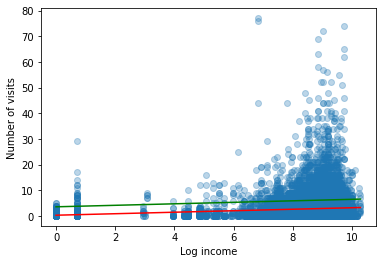

In [21]:
plt.scatter(df.logincome, df.mdvis, alpha=0.3)
plt.xlabel('Log income')
plt.ylabel('Number of visits')

income_linspace = np.linspace(df.logincome.min(), df.logincome.max(), 100)

est = smf.ols(formula='mdvis ~ logincome + hlthp', data=df).fit()

plt.plot(income_linspace, est.params[0] + est.params[1] * income_linspace + est.params[2] * 0, 'r')
plt.plot(income_linspace, est.params[0] + est.params[1] * income_linspace + est.params[2] * 1, 'g')
short_summary(est)

Notice that the two lines are parallel. This is because the categorical variable affects only the intercept and not the slope (which is a function of ``logincome``).

We can then include an interaction term to explore the effect of an interaction between the two -- i.e. we let the slope be different for the two categories.

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5217,0.234,2.231,0.026,0.063,0.980
hlthp,-0.4991,0.890,-0.561,0.575,-2.243,1.245
logincome,0.2630,0.027,9.902,0.000,0.211,0.315
hlthp:logincome,0.4868,0.110,4.441,0.000,0.272,0.702


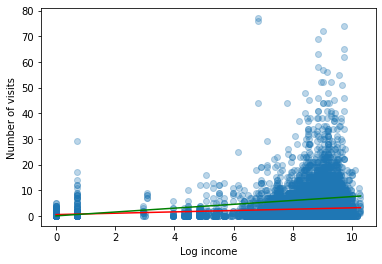

In [22]:
plt.scatter(df.logincome, df.mdvis, alpha=0.3)
plt.xlabel('Log income')
plt.ylabel('Number of visits')

est = smf.ols(formula='mdvis ~ hlthp * logincome', data=df).fit()

plt.plot(income_linspace, est.params[0] + est.params[1] * 0 + est.params[2] * income_linspace +
         est.params[3] * 0 * income_linspace, 'r')
plt.plot(income_linspace, est.params[0] + est.params[1] * 1 + est.params[2] * income_linspace +
         est.params[3] * 1 * income_linspace, 'g')

short_summary(est)

The ``*`` in the formula means that we want the interaction term in addition each term separately (called main-effects). If you want to include just an interaction, use ``:`` instead. This is generally avoided in analysis because it is almost always the case that, if a variable is important due to an interaction, it should have an effect by itself.

To summarize what is happening here:
    
  * If we include the category variables without interactions we have two lines, one for hlthp == 1 and one for hlthp == 0, with all having the same slope but different intercepts.
  * If we include the interactions, now each of the lines can have a different slope. This captures the effect that variation with income may be different for people who are in poor health than for people who are in better health.

For more information on the supported formulas see the documentation of [patsy](http://patsy.readthedocs.org/en/v0.2.1/index.html), used by statsmodels to parse the formula.

## Polynomial regression

Despite its name, linear regression can be used to fit non-linear functions. A linear regression model is linear in the model parameters, not necessarily in the predictors. If you add non-linear transformations of your predictors to the linear regression model, the model will be non-linear in the predictors.

A very popular non-linear regression technique is [Polynomial Regression](http://en.wikipedia.org/wiki/Polynomial_regression), a technique which models the relationship between the response and the predictors as an n-th order polynomial. The higher the order of the polynomial the more "wigglier" functions you can fit. Using higher order polynomial comes at a price, however. First, the computational complexity of model fitting grows as the number of adaptable parameters grows. Second, more complex models have a higher risk of **overfitting**. Overfitting refers to a situation in which the model fits the idiosyncrasies of the training data and loses the ability to generalize from the seen to predict the unseen.

To illustrate polynomial regression we will consider the Boston housing dataset. We'll look into the task to predict median house values in the Boston area using the predictor *lstat*, defined as the "proportion of the adults without some high school education and proportion of male workes classified as laborers" (see [Hedonic House Prices and the Demand for Clean Air, Harrison & Rubinfeld, 1978](http://www.law.berkeley.edu/faculty/rubinfeldd/Profile/publications/Hedonic.PDF)).

We can clearly see that the relationship between *medv* and *lstat* is non-linear: the blue (straight) line is a poor fit; a better fit can be obtained by including higher order terms.

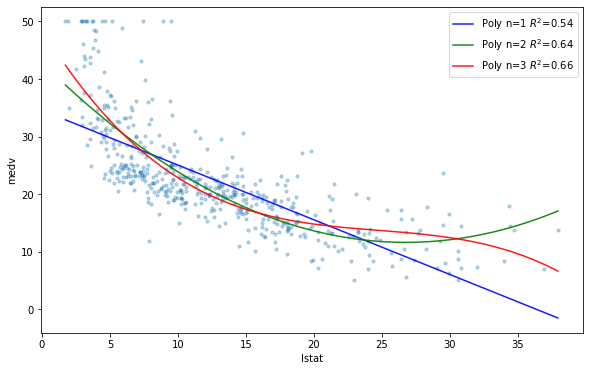

In [23]:
# load the boston housing dataset - median house values in the Boston area
df = pd.read_csv('http://vincentarelbundock.github.io/Rdatasets/csv/MASS/Boston.csv')

# plot lstat (% lower status of the population) against median value
plt.figure(figsize=(6 * 1.618, 6))
plt.scatter(df.lstat, df.medv, s=10, alpha=0.3)
plt.xlabel('lstat')
plt.ylabel('medv')

# points linearlyd space on lstats
x = pd.DataFrame({'lstat': np.linspace(df.lstat.min(), df.lstat.max(), 100)})

# 1-st order polynomial
poly_1 = smf.ols(formula='medv ~ 1 + lstat', data=df).fit()
plt.plot(x.lstat, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared,
         alpha=0.9)

# 2-nd order polynomial
poly_2 = smf.ols(formula='medv ~ 1 + lstat + I(lstat ** 2.0)', data=df).fit()
plt.plot(x.lstat, poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % poly_2.rsquared,
         alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='medv ~ 1 + lstat + I(lstat ** 2.0) + I(lstat ** 3.0)', data=df).fit()
plt.plot(x.lstat, poly_3.predict(x), 'r-', alpha=0.9,
         label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)

plt.legend()

In the legend of the above figure, the $R^2$ value for each of the fits is given. $R^2$ is a measure of how well the model fits the data: a value of one means the model fits the data perfectly while a value of zero means the model fails to explain anything about the data. The fact that the $R^2$ value is higher for the quadratic model shows that it fits the model better than the Ordinary Least Squares model. These $R^2$ values have a major flaw, however, in that they rely exclusively on the same data that was used to train the model. Later on in this series of blog posts, we'll describe some better tools to assess models.

## Appendix

<span id="appendix" />

The code below creates the three dimensional hyperplane plot in the first section.

/home/ebezerra/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
<ipython-input-13-513259a478d7>:22: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, azim=-115, elev=15)


Text(0.5, 0, 'Sales')

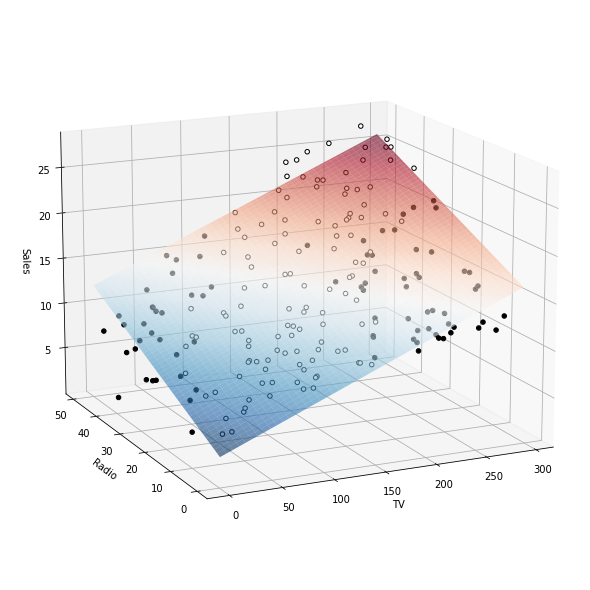

In [13]:
import matplotlib.pyplot as plt

# TODO add image and put this code into an appendix at the bottom
from mpl_toolkits.mplot3d import Axes3D

X = df_adv[['TV', 'Radio']]
y = df_adv['Sales']

## fit a OLS model with intercept on TV and Radio
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()

## Create the 3d plot -- skip reading this
# TV/Radio grid for 3d plot
xx1, xx2 = np.meshgrid(np.linspace(X.TV.min(), X.TV.max(), 100),
                       np.linspace(X.Radio.min(), X.Radio.max(), 100))
# plot the hyperplane by evaluating the parameters on the grid
Z = est.params[0] + est.params[1] * xx1 + est.params[2] * xx2

# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-115, elev=15)

# plot hyperplane
surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)

# plot data points - points over the HP are white, points below are black
resid = y - est.predict(X)
ax.scatter(X[resid >= 0].TV, X[resid >= 0].Radio, y[resid >= 0], color='black', alpha=1.0, facecolor='white')
ax.scatter(X[resid < 0].TV, X[resid < 0].Radio, y[resid < 0], color='black', alpha=1.0)

# set axis labels
ax.set_xlabel('TV')
ax.set_ylabel('Radio')
ax.set_zlabel('Sales')